In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import gurobipy as gp
from gurobipy import GRB

from general_graph_utils import *

The BHH theorem tells us that if we have a Euclidean manifold on which there is a collection of points we want to visit, viewed as random variables, then the minimum length of the tours that hits all points has a nice upper bound. This upper bound guarantees nice behavior.

Here, we seek to understand if the BHH theorem can help us understand the asymptotic and dynamic behavior of delays in air transportation networks. We associated with each node of the network a probability distribution, and want to understand how delays propagate. There is a deterministic spreading process of delays, and these delays can propagate throughout the entire network.

We start by building a graph that contains all ARR and DEP airports as the set of nodes, and some edges to represent the set of active flights. Randomness will allow us the creation of a new node. The goal is to link propagation behavior of the signals through a random graph.

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[rosetta2] - Darwin 23.2.0 23C64)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 92 rows, 110 columns and 396 nonzeros
Model fingerprint: 0x48d6eb23
Variable types: 10 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 5.8394810
Presolve removed 0 rows and 11 columns
Presolve time: 0.00s
Presolved: 92 rows, 99 columns, 396 nonzeros
Variable types: 9 continuous, 90 integer (90 binary)

Root relaxation: objective 2.815643e+00, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.81564    0   10    5.83948    2.81564  51.8% 

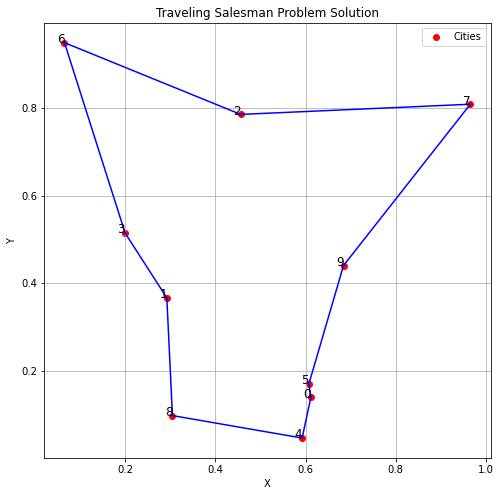

In [4]:
# Generate random points in the unit square
def generate_points(num_points):
    #np.random.seed(42)  # For reproducibility
    return np.random.rand(num_points, 2)

# Calculate pairwise Euclidean distances
def calculate_distances(points):
    num_points = len(points)
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = np.linalg.norm(points[i] - points[j])
    return distances

# Solve the TSP using Gurobi
def solve_tsp(distances):
    num_points = len(distances)
    model = gp.Model()

    # Decision variables: x[i, j] is 1 if the tour goes directly from i to j
    x = model.addVars(num_points, num_points, vtype=GRB.BINARY, name="x")

    # Objective: minimize total distance
    model.setObjective(gp.quicksum(distances[i][j] * x[i, j] for i in range(num_points) for j in range(num_points)), GRB.MINIMIZE)

    # Constraints: each node must have exactly one incoming and one outgoing edge
    model.addConstrs(gp.quicksum(x[i, j] for j in range(num_points) if j != i) == 1 for i in range(num_points))
    model.addConstrs(gp.quicksum(x[j, i] for j in range(num_points) if j != i) == 1 for i in range(num_points))

    # Subtour elimination constraints (MTZ formulation)
    u = model.addVars(num_points, vtype=GRB.CONTINUOUS, name="u")
    model.addConstrs((u[i] - u[j] + num_points * x[i, j] <= num_points - 1) for i in range(1, num_points) for j in range(1, num_points) if i != j)

    # Optimize the model
    model.optimize()

    # Extract the solution
    tour = []
    if model.status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        for i in range(num_points):
            for j in range(num_points):
                if solution[i, j] > 0.5:  # Edge is part of the tour
                    tour.append((i, j))
    return tour

# Plot the TSP solution
def plot_solution(points, tour):
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], c='red', label='Cities')
    for i, (x, y) in enumerate(points):
        plt.text(x, y, str(i), fontsize=12, ha='right')

    for i, j in tour:
        plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-')

    plt.title("Traveling Salesman Problem Solution")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    num_points = 10
    points = generate_points(num_points)
    distances = calculate_distances(points)
    tour = solve_tsp(distances)
    plot_solution(points, tour)

if __name__ == "__main__":
    main()


In [7]:
def expected_tour_length_bhh(num_points):
    beta_2 = 0.712  # BHH constant for 2D
    area = 1        # Unit square
    return beta_2 * np.sqrt(num_points)

# Example usage
num_points = 10
expected_length = expected_tour_length_bhh(num_points)
print(f"Expected tour length for {num_points} points: {expected_length:.4f}")

Expected tour length for 10 points: 2.2515


In [78]:
G = nx.DiGraph()
G_size = 8
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

# no flights b/w EWR-LGA, EWR-PHL, PHL-LGA, DCA-IAD, BWI-DCA
# flights from BOS, JFK, IAD to everywhere else
G.add_edge(1,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,5, weight = np.random.choice(np.arange(1,10), size=1))

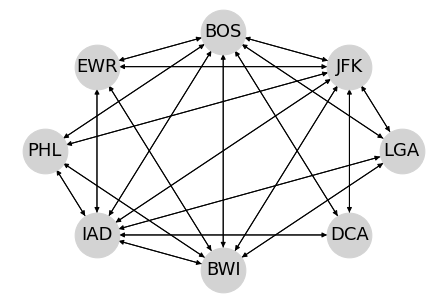

In [79]:
node_labels = {}
node_labels[1] = "LGA"
node_labels[2] = "JFK"
node_labels[3] = "BOS"
node_labels[4] = "EWR"
node_labels[5] = "PHL"
node_labels[6] = "IAD"
node_labels[7] = "BWI"
node_labels[8] = "DCA"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

Certain tours will delay the spreading of dealys. A tour in this context is a set of flights that don't go back. A tour of degree 2 is a tour that is not allowed to revisit a node. We can make a more relaxed tour that allows for some backtracking.

One of our goals is figuring out how ot translate BHH (which is a property of the length of a tour) into some aspect of time. The J Michael Steele paper has different types of extensions of the BHH to different types of graphs.

In [80]:
list(nx.eulerian_circuit(G,source=1))

[(1, 7),
 (7, 6),
 (6, 8),
 (8, 3),
 (3, 8),
 (8, 2),
 (2, 8),
 (8, 6),
 (6, 7),
 (7, 5),
 (5, 6),
 (6, 5),
 (5, 7),
 (7, 4),
 (4, 6),
 (6, 4),
 (4, 7),
 (7, 3),
 (3, 6),
 (6, 3),
 (3, 5),
 (5, 3),
 (3, 4),
 (4, 3),
 (3, 7),
 (7, 2),
 (2, 6),
 (6, 2),
 (2, 5),
 (5, 2),
 (2, 4),
 (4, 2),
 (2, 3),
 (3, 2),
 (2, 7),
 (7, 1),
 (1, 6),
 (6, 1),
 (1, 3),
 (3, 1),
 (1, 2),
 (2, 1)]

In [82]:
vertices = [u for u, v in nx.eulerian_circuit(G)]

In [83]:
for i in range(len(vertices)):
    print(node_labels[vertices[i]])

LGA
BWI
IAD
DCA
BOS
DCA
JFK
DCA
IAD
BWI
PHL
IAD
PHL
BWI
EWR
IAD
EWR
BWI
BOS
IAD
BOS
PHL
BOS
EWR
BOS
BWI
JFK
IAD
JFK
PHL
JFK
EWR
JFK
BOS
JFK
BWI
LGA
IAD
LGA
BOS
LGA
JFK
